# Auf dem Trockenen

This notebook should show the capabilities of GeoEngine. Therefore a few useful techniques will be shown: 
- Usage of the GBIF data catalog
- Point in Polygon selection
- Raster Vector Join of occurence data with land use classification
- Plotting of a class histogram
- Nested Workflows

It is recommended when building a own nested workflow to build it in multiple steps as seen in this notebook.

Documentation about the Operators and how to use them in Python can be found here: [https://docs.geoengine.io/operators/intro.html](https://docs.geoengine.io/operators/intro.html)

## Preparation

In [25]:
#Import packages
import geoengine as ge
import geoengine_openapi_client
from datetime import datetime
from geoengine.types import RasterBandDescriptor
import altair as alt

alt.renderers.enable('default')

RendererRegistry.enable('default')

In [26]:
#Initialize GeoEngine in VAT
ge.initialize("https://vat.gfbio.org/api")

In [27]:
#Get the GBIF DataProvider id (Useful to translate the DataProvider name into the respective id)
root_collection = ge.layer_collection()
gbif_prov_id = ''
for elem in root_collection.items:
    if elem.name == 'GBIF':
        gbif_prov_id = str(elem.provider_id)
        
gbif_prov_id

'1c01dbb9-e3ab-f9a2-06f5-228ba4b6bf7a'

## Load Boundaries of Germany for later cutting GBIF occurence out (Optional)

This chapter is not needed and only shows that country boundaries are available

In [28]:
#Create workflow to request germany boundary
workflow_germany = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "OgrSource",
        "params": {
            "data": "germany",
        }
    }
})

workflow_germany

2429a993-385f-546f-b4f7-97b3ba4a5adb

<Axes: >

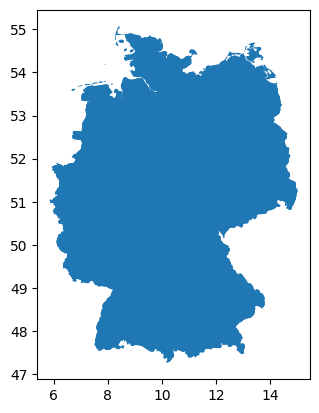

In [29]:
#Set time
time = datetime.strptime(
    '2000-01-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geoengine into a geopandas dataframe
data = workflow_germany.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot()

## Load Ökosystematlas (Detailliert) for later Raster Vector Join with the occurence data (Optional)

This chapter is not needed and only shows that also raster data is available

In [30]:
#Create workflow to request the oekosystematlas raster data
workflow_oekosystematlas = ge.register_workflow({ 
    "type": "Raster",
    "operator": {
        "type": "GdalSource",
        "params": {
            "data": "oekosystematlas_detail"
        }
    }
})

workflow_oekosystematlas

f447601c-0ba1-57c3-9127-b0622f982231

/home/duempelmann/geoengine_env/lib/python3.10/site-packages/owslib/coverage/wcs110.py:85: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  elem = self._capabilities.find(self.ns.OWS('ServiceProvider')) or self._capabilities.find(self.ns.OWS('ServiceProvider'))  # noqa


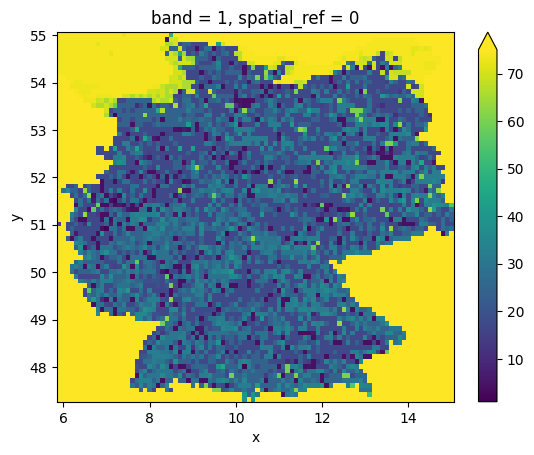

In [31]:
#Set time
time = datetime.strptime(
    '2000-01-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geoengine into a xarray dataarray
data = workflow_oekosystematlas.get_xarray(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot(vmax=75)

## Load Average temperature for later Raster Vector Join with the occurence data (Optional)

This chapter is not needed and only shows that also raster data is available

In [32]:
#Create workflow to request the average temperature raster data
workflow_t_avg = ge.register_workflow({ 
    "type": "Raster",
    "operator": {
        "type": "GdalSource",
        "params": {
            "data": "tavg"
        }
    }
})

workflow_t_avg

b92f5a60-aeb1-57ac-a434-7ec7e2869ddb

/home/duempelmann/geoengine_env/lib/python3.10/site-packages/owslib/coverage/wcs110.py:85: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  elem = self._capabilities.find(self.ns.OWS('ServiceProvider')) or self._capabilities.find(self.ns.OWS('ServiceProvider'))  # noqa


/home/duempelmann/geoengine_env/lib/python3.10/site-packages/matplotlib/colors.py:718: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


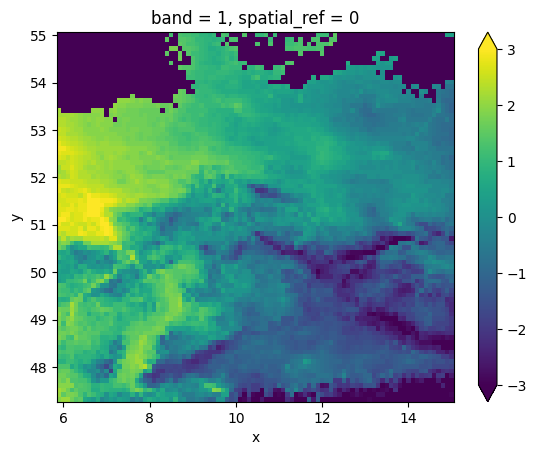

In [33]:
#Set time
time = datetime.strptime(
    '2000-01-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geoengine into a xarray dataarray
data = workflow_t_avg.get_xarray(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot(vmin=-3, vmax=3)

## Processing Calopteryx splendens

Non of the following steps are in theory necessary as the whole workflow will be projected in the nested request in the end. The steps should show though the possibilities GeoEngine gives.

### Load Calopteryx splendens (Optional)

In [35]:
#Create workflow to request Calopteryx splendens occurences
workflow_calopteryx_splendens = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "OgrSource",
        "params": {
            "data": f"_:{gbif_prov_id}:`species/Calopteryx splendens`",
        }
    }
})

workflow_calopteryx_splendens.get_result_descriptor()

Data type:         MultiPoint
Spatial Reference: EPSG:4326
Columns:
  scientificname:
    Column Type: text
    Measurement: unitless
  gbifid:
    Column Type: int
    Measurement: unitless
  basisofrecord:
    Column Type: text
    Measurement: unitless

<Axes: >

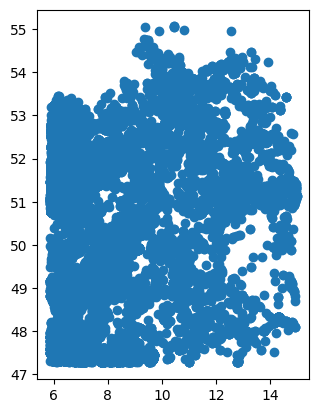

In [36]:
#Set time
time = datetime.strptime(
    '2000-01-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geoengine into a geopandas dataframe
data = workflow_calopteryx_splendens.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot()

### Point in Polygon Calopteryx splendens

In [37]:
#Create workflow to request Calopteryx splendens occurences filtered by german boundary
workflow_calopteryx_splendens_cut = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "PointInPolygonFilter",
        "params": {},
        "sources": {
            "points": { #Calopteryx splendens ###############################
                "type": "OgrSource",
                "params": {
                    "data": f"_:{gbif_prov_id}:`species/Calopteryx splendens`",
                    "attributeProjection": []
                } 
            }, #####################################################
            "polygons": { #Germany #################################
                "type": "OgrSource",
                "params": {
                    "data": "germany"
                }
            } ######################################################
        } 
    }
})

workflow_calopteryx_splendens_cut

6cf9ef88-8bd3-5904-bc74-f866165b18c3

<Axes: >

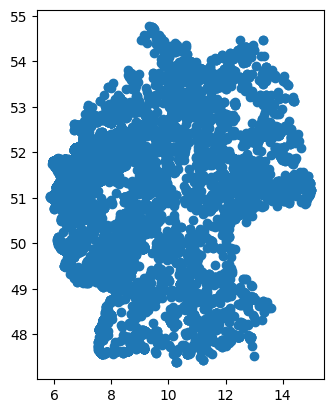

In [38]:
#Set time
time = datetime.strptime(
    '2000-01-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geoengine into a geopandas dataframe
data_calopteryx_splendens = workflow_calopteryx_splendens_cut.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data_calopteryx_splendens.plot()

### Nested Point in Polygon and Raster Vector Join Calopteryx splendens

In [39]:
#Create workflow to request Calopteryx splendens occurences filtered by german boundary and joined with the Ökosystematlas data
workflow_calopteryx_splendens_cut_join = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "RasterVectorJoin",
        "params": {
                "names": ["Ökosystematlas", "Avg_Temperature"],
                "temporalAggregation": "none",
                "featureAggregation": "mean",
        },
        "sources": {
            "vector": { #Calopteryx splendens cut ######################################
                "type": "PointInPolygonFilter", 
                "params": {},
                "sources": {
                    "points": {
                        "type": "OgrSource",
                        "params": {
                            "data": f"_:{gbif_prov_id}:`species/Calopteryx splendens`",
                            "attributeProjection": []
                        }
                    },
                    "polygons": {
                        "type": "OgrSource",
                        "params": {
                            "data": "germany"
                        }
                    }
                }
            }, ##############################################################
            "rasters": [{ #Ökosystematlas ###################################
                "type": "GdalSource",
                "params": {
                    "data": "oekosystematlas"
                }
            }, ##############################################################
            { #Average temperature
                "type": "GdalSource",
                "params": {
                    "data": "tavg"
                }
            }] ##############################################################
        },
    }
})

workflow_calopteryx_splendens_cut_join

7a168f72-ec0c-5387-ae5f-e494bff308a3

In [40]:
#Set time
time = datetime.strptime(
    '2000-01-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geoengine into a geopandas dataframe
data = workflow_calopteryx_splendens_cut_join.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Show the geopandas dataframe
data

,geometry,Avg_Temperature,basisofrecord,gbifid,scientificname,Ökosystematlas,start,end
0,POINT (6.05000 51.10000),2.6,HUMAN_OBSERVATION,1964151889,"Calopteryx splendens Harris, 1780",6.0,2000-01-01 00:00:00+00:00,2000-02-01 00:00:00+00:00
1,POINT (7.11510 50.77208),2.7,HUMAN_OBSERVATION,2833395438,"Calopteryx splendens Harris, 1780",8.0,2000-01-01 00:00:00+00:00,2000-02-01 00:00:00+00:00
2,POINT (6.15000 51.10000),2.8,HUMAN_OBSERVATION,3906557864,"Calopteryx splendens Harris, 1780",6.0,2000-01-01 00:00:00+00:00,2000-02-01 00:00:00+00:00
3,POINT (6.10000 51.85000),2.8,HUMAN_OBSERVATION,1959967974,"Calopteryx splendens Harris, 1780",6.0,2000-01-01 00:00:00+00:00,2000-02-01 00:00:00+00:00
4,POINT (9.54518 51.60248),0.8,HUMAN_OBSERVATION,3904184452,"Calopteryx splendens Harris, 1780",11.0,2000-01-01 00:00:00+00:00,2000-02-01 00:00:00+00:00
...,...,...,...,...,...,...,...,...
18030,POINT (7.84776 49.83018),1.4,HUMAN_OBSERVATION,3785030169,"Calopteryx splendens Harris, 1780",7.0,2000-01-01 00:00:00+00:00,2000-02-01 00:00:00+00:00
18031,POINT (8.12045 47.83454),-2.0,HUMAN_OBSERVATION,3337757385,"Calopteryx splendens Harris, 1780",11.0,2000-01-01 00:00:00+00:00,2000-02-01 00:00:00+00:00
18032,POINT (8.95025 48.78821),0.3,HUMAN_OBSERVATION,412400404,"Calopteryx splendens Harris, 1780",2.0,2000-01-01 00:00:00+00:00,2000-02-01 00:00:00+00:00
18033,POINT (9.40128 54.63782),0.8,HUMAN_OBSERVATION,3320928988,"Calopteryx splendens Harris, 1780",8.0,2000-01-01 00:00:00+00:00,2000-02-01 00:00:00+00:00


It can be seen that the variable 'Ökosystematlas' is numerical, while the classes are human-readably coded in the files metadata. This can be adapted using a Class Histogram

## Nested Full Workflow Calopteryx splendens Plot Ökosystematlas

In [41]:
#Create workflow to plot Calopteryx splendens occurences filtered by german boundary and joined with the Ökosystematlas data as a class histogram
workflow_calopteryx_splendens_full_öko = ge.register_workflow({
    "type": "Plot",
    "operator": {
       "type": "ClassHistogram",
       "params": {
          "columnName": "Ökosystematlas"
       },
        "sources": {
            "source": { #Calopteryx splendens cut join #####################################
                "type": "RasterVectorJoin",
                "params": {
                        "names": ["Ökosystematlas", "Avg_Temperature"],
                        "temporalAggregation": "none",
                        "featureAggregation": "mean",
                },
                "sources": {
                    "vector": {
                        "type": "PointInPolygonFilter",
                        "params": {},
                        "sources": {
                            "points": {
                                "type": "OgrSource",
                                "params": {
                                    "data": f"_:{gbif_prov_id}:`species/Calopteryx splendens`",
                                    "attributeProjection": []
                                }
                            },
                            "polygons": {
                                "type": "OgrSource",
                                "params": {
                                    "data": "germany"
                                }
                            }
                        }
                    },
                    "rasters": [{
                        "type": "GdalSource",
                        "params": {
                            "data": "oekosystematlas"
                        }
                    },
                    {
                        "type": "GdalSource",
                        "params": {
                            "data": "tavg"
                        }
                    }]
                }
            } ######################################################################
       }
    }
})
    
workflow_calopteryx_splendens_full_öko

991d87e1-77fd-5263-a60c-0236f16369b1

In [42]:
#Request the plot from Geoengine
plot_calopteryx_splendens = workflow_calopteryx_splendens_full_öko.plot_chart(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Show the plot
alt.Chart.from_dict(plot_calopteryx_splendens.spec)

alt.Chart(...)

## Nested Full Workflow Calopteryx splendens Plot Average Temperature

In [43]:
#Create workflow to request Calopteryx splendens occurences filtered by german boundary and joined with the Ökosystematlas data
workflow_calopteryx_splendens_full_avg_temp = ge.register_workflow({
    "type": "Vector",
    "operator": {
        "type": "RasterVectorJoin",
        "params": {
                "names": ["Ökosystematlas", "Avg_Temperature"],
                "temporalAggregation": "none",
                "featureAggregation": "mean",
        },
        "sources": {
            "vector": {
                "type": "PointInPolygonFilter", 
                "params": {},
                "sources": {
                    "points": {
                        "type": "OgrSource",
                        "params": {
                            "data": f"_:{gbif_prov_id}:`species/Calopteryx splendens`",
                            "attributeProjection": []
                        }
                    },
                    "polygons": {
                        "type": "OgrSource",
                        "params": {
                            "data": "germany"
                        }
                    }
                }
            },
            "rasters": [{
                "type": "GdalSource",
                "params": {
                    "data": "oekosystematlas"
                }
            },
            {
                "type": "GdalSource",
                "params": {
                    "data": "tavg"
                }
            }]
        },
    }
})

workflow_calopteryx_splendens_full_avg_temp

7a168f72-ec0c-5387-ae5f-e494bff308a3

<Axes: >

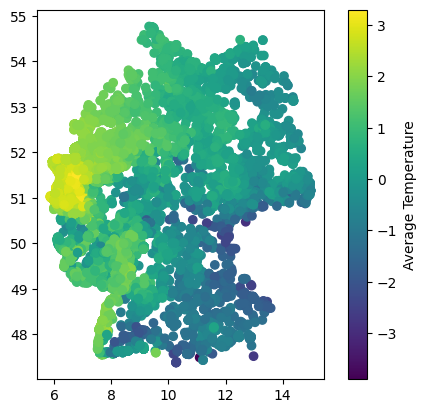

In [44]:
#Set time
time = datetime.strptime(
    '2000-01-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geoengine into a geopandas dataframe
data = workflow_calopteryx_splendens_full_avg_temp.get_dataframe(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Show the geopandas dataframe
data.plot(column='Avg_Temperature', legend=True, legend_kwds={'label': 'Average Temperature'})

# Further experiments

In this chapter some further useful uses between geoengine and python are shown

/home/duempelmann/geoengine_env/lib/python3.10/site-packages/owslib/coverage/wcs110.py:85: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  elem = self._capabilities.find(self.ns.OWS('ServiceProvider')) or self._capabilities.find(self.ns.OWS('ServiceProvider'))  # noqa
/home/duempelmann/geoengine_env/lib/python3.10/site-packages/matplotlib/colors.py:718: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


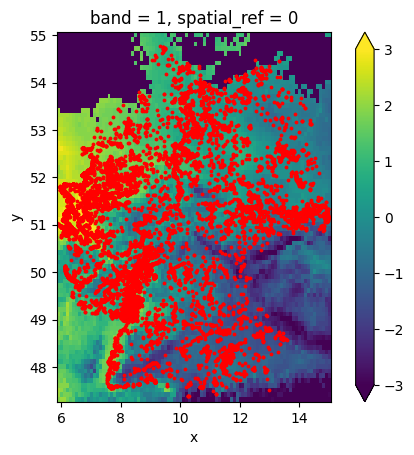

In [45]:
#Overlay plot with context
import geopandas as gpd
import matplotlib.pyplot as plt
#Set time
time = datetime.strptime(
    '2000-01-01T12:00:00.000Z', "%Y-%m-%dT%H:%M:%S.%f%z")

#Request the data from Geoengine into a xarray dataarray
data = workflow_t_avg.get_xarray(
    ge.QueryRectangle(
        ge.BoundingBox2D(5.852490, 47.271121, 15.022059, 55.065334),
        ge.TimeInterval(time, time),
        resolution=ge.SpatialResolution(0.1, 0.1),
        srs="EPSG:4326"
    )
)

#Plot the data
data.plot(vmin=-3, vmax=3)
data_calopteryx_splendens.plot(ax=plt.gca(), color='red', markersize=3)
plt.show()